In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json

from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.metrics import *
import time
from datetime import datetime
import os
from torch.utils import data
import random
import copy
import itertools
import io
import uuid
from sklearn.model_selection import KFold, train_test_split

import warnings
warnings.filterwarnings('ignore')

import wandb
wandb_username = 'moturuab'
local_username = 'abhishekmoturu'

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:1') 
else:
    device = torch.device('cpu')
#device = torch.device('cpu')
print(device)

cuda:1


In [3]:
# source: https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
#example-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm,fold, classnames, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classnames))
    plt.xticks(tick_marks, classnames, rotation=45)
    plt.yticks(tick_marks, classnames)
    
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=19)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('ViewNetConfMtrx' + fold + '.png')
    wandb.log({"confusion"+ fold: plt})

In [4]:
# root directory
root_dir = "/home/andreasabo/Documents/HNProject/"
split_file_base = "/home/andreasabo/Documents/HNUltra/"

# data directory on current machine: abhishekmoturu, andreasabo, denizjafari, navidkorhani
data_dir = "/home/" + local_username + "/Documents/HNProject/all_label_img/"

# read target df
csv_path = os.path.join(root_dir, "all_splits_1000000.csv")
data_df = pd.read_csv(csv_path, usecols=['subj_id', 'image_ids', 'view_label', 'view_train'])

# Are we doing the final test?
test_data = False

### **Reading Data Indicies and Labels**

In [5]:
label_mapping = {'Other':0, 'Saggital_Right':1, 'Transverse_Right':2, 
                 'Saggital_Left':3, 'Transverse_Left':4, 'Bladder':5}
label_unmapping = {0: 'Other', 1:'Saggital_Right', 2: 'Transverse_Right', 
                   3:'Saggital_Left', 4:'Transverse_Left', 5: 'Bladder'}
classnames = ['Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left', 'Transverse_Left', 'Bladder']

data_df['view_label'] = data_df['view_label'].map(label_mapping)

train_df = data_df[data_df.view_train == 1]
test_df = data_df[data_df.view_train == 0]

unique_subj = train_df.subj_id.unique()

# Create the splits for 5-fold cross validation based on subj_id
data_split_file = split_file_base + 'data_splits.json'
if not os.path.isfile(data_split_file):

    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    fold = 0
    all_folds = {}
    for train_subj, val_subj in kf.split(unique_subj):
        train_ids  = unique_subj[train_subj]
        val_ids = unique_subj[val_subj]

        train_images = train_df[train_df.subj_id.isin(train_ids)].image_ids.tolist()
        val_images = train_df[train_df.subj_id.isin(val_ids)].image_ids.tolist()
        train_labels = train_df[train_df.subj_id.isin(train_ids)].view_label.tolist()
        val_labels = train_df[train_df.subj_id.isin(val_ids)].view_label.tolist()
        cur_fold = {'train_ids': train_images, 'valid_ids': val_images, 'train_labels': train_labels, 'valid_labels': val_labels}
        all_folds[fold] = cur_fold
        fold += 1

    print("Saving data splits")
    with open(data_split_file, 'w') as f:
        json.dump(all_folds, f)
        
else: # just load from file
    print("Reading splits from file")
    with open(data_split_file, 'r') as f:
        all_folds = json.load(f)

# If we're testing, overwrite the training data with the entire train/test data
if test_data:
    train_images = train_df.image_ids.tolist()
    val_images = test_df.image_ids.tolist()
    train_labels = train_df.view_label.tolist()
    val_labels = test_df.view_label.tolist()

    cur_fold = {'train_ids': train_images, 'valid_ids': val_images, 'train_labels': train_labels, 'valid_labels': val_labels}

    all_folds['test'] = cur_fold
    
test_images = test_df.image_ids.tolist()
#    train_labels = train_df.view_label.tolist()
test_labels = test_df.view_label.tolist()

test_set = {'test_ids': test_images, 'test_labels': test_labels}

Reading splits from file


In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 256

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    elif model_name == 'viewnet':
        conv1_filters = 8
        conv2_filters = 16
        conv3_filters = 32
        linear1_size = 512
        dropout = 0.25
        model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)
        input_size = 256
        
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


class ViewNet(nn.Module):

    def __init__(self, num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout):
        super(ViewNet, self).__init__()
        self.conv1_filters = conv1_filters
        self.conv2_filters = conv2_filters
        self.conv3_filters = conv3_filters
        self.linear1_size = linear1_size
        self.drop_percent = dropout
        self.max_pool = 4
        self.conv_output = int(self.conv3_filters*(256/(self.max_pool**3))*(256/(self.max_pool**3)))
        print("conv_output: ", self.conv_output)

        
        self.conv1 = nn.Conv2d(1, self.conv1_filters, 4, padding=2)
        self.conv2 = nn.Conv2d(self.conv1_filters, self.conv2_filters, 4, padding=2)
        self.conv3 = nn.Conv2d(self.conv2_filters, self.conv3_filters, 4, padding=2)
        self.pool = nn.MaxPool2d(self.max_pool, self.max_pool)
        self.dropout = nn.Dropout(self.drop_percent)
        self.linear1 = nn.Linear(self.conv_output, self.linear1_size)
        self.linear2 = nn.Linear(self.linear1_size, num_classes)
    
    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.conv1(x))))
        x = self.pool(self.dropout(F.relu(self.conv2(x))))
        x = self.pool(self.dropout(F.relu(self.conv3(x))))
        x = x.view(-1, self.conv_output) 
        x = self.dropout(F.relu((self.linear1(x))))
        x = self.linear2(x)
        return x

In [8]:
# Code from: https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=True):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [9]:
def train_model(model_bladder, model_trans_right, model_trans_left, model_sag_right, model_sag_left, model_other, dataloaders): #, criterion, optimizer, num_epochs=25, is_inception=False, final_testing=False):
    #es = EarlyStopping(patience = 15)
    #stop_now = 0

    since = time.time()
    classnames = ['Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left','Transverse_Left', 'Bladder']
    val_acc_history = []
    
    val_metrics_list = []
    train_metrics_list = []
    
    #best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_with_best_val_acc = 0
    for epoch in range(1):
        print('Epoch {}/{}'.format(epoch + 1, 1))
        print('-' * 54)

        #if stop_now:
        #    break
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            model_bladder.eval()   # Set model to evaluate mode
            model_trans_right.eval()
            model_trans_left.eval()
            model_sag_right.eval()
            model_sag_left.eval()
            model_other.eval()

            #running_loss = 0.0
            running_corrects = 0
            
            running_preds = []
            running_labels = []

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                labels = labels.type(torch.long)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                #optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    #if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                    #    outputs, aux_outputs = model(inputs)
                    #    loss1 = criterion(outputs, labels)
                    #    loss2 = criterion(aux_outputs, labels)
                    #    loss = loss1 + 0.4*loss2
                    #else:
                    # label_mapping = {'Other':0, 'Saggital_Right':1, 'Transverse_Right':2, 'Saggital_Left':3, 'Transverse_Left':4, 'Bladder':5}
                    s = nn.Sigmoid()
                    outputs = s(model_other(inputs))
                    outputs = torch.cat((outputs, s(model_sag_right(inputs))), 1)
                    outputs = torch.cat((outputs, s(model_trans_right(inputs))), 1)
                    outputs = torch.cat((outputs, s(model_sag_left(inputs))), 1)
                    outputs = torch.cat((outputs, s(model_trans_left(inputs))), 1)
                    outputs = torch.cat((outputs, s(model_bladder(inputs))), 1)

                    labels = torch.argmax(labels, 1)
                    running_preds += torch.argmax(outputs, 1).tolist()
                    running_labels += labels.tolist()
                    #loss = criterion(outputs, labels)

                    preds = torch.argmax(outputs, 1)

                    # backward + optimize only if in training phase
                    #if phase == 'train':
                    #    loss.backward()
                    #    optimizer.step()

                # statistics
                #running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            #print('{} loss:\t{:.4f} | {} acc:\t{:.4f}\n'.format(phase, epoch_loss, phase, epoch_acc))

            if phase == 'train':
                wandb.log({'epoch': epoch, 'train_acc':epoch_acc})
                
                cur_train_metrics = {}
                                # compute and log f1, precision, recall for each class
                for c in range(6):
                    running_labels = np.asarray(running_labels)
                    running_preds = np.asarray(running_preds)

                    cur_c_labs_bin = np.asarray([0] *len(running_labels))
                    cur_c_preds_bin = np.asarray([0] *len(running_labels))

                    # Need to binarize
                    cur_c_preds_bin[running_preds == c] = 1
                    cur_c_labs_bin[running_labels == c] = 1
                    f1 = f1_score(cur_c_labs_bin, cur_c_preds_bin)
                    precision = precision_score(cur_c_labs_bin, cur_c_preds_bin)
                    recall = recall_score(cur_c_labs_bin, cur_c_preds_bin)
                    
                    cur_train_metrics['train_' + label_unmapping[c] + '_f1'] = f1
                    cur_train_metrics['train_' + label_unmapping[c] + '_precision'] = precision
                    cur_train_metrics['train_' + label_unmapping[c] + '_recall'] = recall
                    
                
                train_metrics_list.append(cur_train_metrics)
                
                average_types = ['macro', 'micro', 'weighted']
                average_metrics_to_log = ['precision', 'recall', 'f1score', 'support']
                average_dict = {'epoch': epoch}
                for av in average_types:
                    results_tuple = precision_recall_fscore_support(running_labels, running_preds, average=av)
                    for m in range(len(average_metrics_to_log)):      
                        average_dict[phase + '_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                        cur_train_metrics[phase + '_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                cur_train_metrics[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)                  
                average_dict[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)     
                wandb.log(cur_train_metrics)
                
            if phase == 'val':
                wandb.log({'valid_acc':epoch_acc, 'epoch': epoch})
               
            
                cur_val_metrics = {}
                # compute and log f1, precision, recall for each class
                for c in range(6):
                    running_labels = np.asarray(running_labels)
                    running_preds = np.asarray(running_preds)

                    cur_c_labs_bin = np.asarray([0] *len(running_labels))
                    cur_c_preds_bin = np.asarray([0] *len(running_labels))

                    # Need to binarize
                    cur_c_preds_bin[running_preds == c] = 1
                    cur_c_labs_bin[running_labels == c] = 1
                    f1 = f1_score(cur_c_labs_bin, cur_c_preds_bin)
                    precision = precision_score(cur_c_labs_bin, cur_c_preds_bin)
                    recall = recall_score(cur_c_labs_bin, cur_c_preds_bin)
                    wandb.log({'valid_' + label_unmapping[c] + '_f1': f1})
                    wandb.log({'valid_' + label_unmapping[c] + '_precision': precision})
                    wandb.log({'valid_' + label_unmapping[c] + '_recall': recall})
                
                    cur_val_metrics['val_' + label_unmapping[c] + '_f1'] = f1
                    cur_val_metrics['val_' + label_unmapping[c] + '_precision'] = precision
                    cur_val_metrics['val_' + label_unmapping[c] + '_recall'] = recall
                
                average_types = ['macro', 'micro', 'weighted']
                average_metrics_to_log = ['precision', 'recall', 'f1score']
                average_dict = {'epoch': epoch}
                for av in average_types:
                    results_tuple = precision_recall_fscore_support(running_labels, running_preds, average=av)
                    for m in range(len(average_metrics_to_log)):      
                        average_dict[phase + '_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                        cur_val_metrics[phase + '_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                cur_val_metrics[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)                  
                average_dict[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)     
                print(cur_val_metrics)
                wandb.log(cur_val_metrics)
                
                
                val_metrics_list.append(cur_val_metrics)
                
            #print(classification_report(running_labels, running_preds))
            
            if phase == 'train':
                print(classification_report(running_labels, running_preds))
                train_acc = epoch_acc
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_acc_train = train_acc
                epoch_with_best_val_acc = epoch
                #best_model_wts = copy.deepcopy(model.state_dict())
                #torch.save(model.state_dict(), os.path.join(wandb.run.dir, "model.pt"))
                print(classification_report(running_labels, running_preds))
            '''
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                if es.step(epoch_loss) and not final_testing:
                    stop_now = 1
                    print("EARLY STOPPING " + str(epoch))
                    break
            '''

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}\n'.format(best_acc))
    
    # Directly save the best results in this fold
    metrics_from_best_epoch = {'best_epoch': epoch_with_best_val_acc, 'last_epoch': epoch}
    metrics_from_best_epoch.update( val_metrics_list[0] )
    metrics_from_best_epoch.update( train_metrics_list[0] )
    metrics_from_best_epoch.update( {'val_acc': best_acc.data.cpu(), 'train_acc': best_acc_train.data.cpu()} )
    '''
    wandb.config.best_acc = best_acc
    wandb.config.best_epoch = epoch_with_best_val_acc

    wandb.config.val_acc_history = val_acc_history
    wandb.config.best_epoch = epoch_with_best_val_acc
    
    wandb.config.update(val_metrics_list[epoch_with_best_val_acc])
    wandb.config.update(train_metrics_list[epoch_with_best_val_acc])
    
    metrics_from_best_epoch = {'best_epoch': epoch_with_best_val_acc, 'last_epoch': epoch}
    metrics_from_best_epoch.update( val_metrics_list[epoch_with_best_val_acc] )
    metrics_from_best_epoch.update( train_metrics_list[epoch_with_best_val_acc] )
    metrics_from_best_epoch.update( {'val_acc': best_acc.data.cpu(), 'train_acc': best_acc_train.data.cpu()} )    
    
    # load best model weights
    #model.load_state_dict(best_model_wts)
    '''
    return metrics_from_best_epoch #model, val_acc_history, metrics_from_best_epoch

In [10]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels, transformations=None):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.transformations = transformations
        
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        img_path = data_dir + ID + '.jpg'
        image = Image.open(img_path) #.convert('L')
        
        if self.transformations:
            image = self.transformations(image)
        
        image = ToTensor()(image)
        
        y = torch.FloatTensor([0]*6)        
        y[int(self.labels[index])] = 1

        return image, y, ID

In [11]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, viewnet]
model_name = "viewnet"

# Number of classes in the dataset: right_sag, right_trav, left_sag, left_trav, bladder, other
num_classes = 1

# Batch size for training (change depending on how much memory you have)
batch_size = 5

# Number of epochs to train for
num_epochs = 1

# Flag for feature extracting. When False, we finetune the whole model; when True we only update the reshaped layer params
feature_extract = False

# Flag for whether or not to use pretrained model
pretrain = False

In [12]:
def train5fold(network_configs, lr, wd, amsgrad, i):
    folds = ['test']
    folds = ['0', '1', '2', '3', '4']
    project_name = 'hnultra'
    random_str = str(uuid.uuid4()).split("-")[0]
    best_metrics_per_fold = []
    test_metrics_per_fold = []
    final_df = pd.DataFrame()
    for fold in folds:
        torch.cuda.empty_cache()

        now = datetime.now()
        date_time = now.strftime("%d-%m-%Y.%H:%M:%S")
        wandb.init(project=project_name, entity=wandb_username, name=local_username + '_fold_' + fold, group=random_str)
        partition = all_folds[fold]

        model_bladder = models.resnet18()
        num_ftrs = model_bladder.fc.in_features
        model_bladder.fc = nn.Linear(num_ftrs, num_classes)
        model_bladder.load_state_dict(torch.load('binary_models/model_bladder_fold_'+str(fold)+'.pt'))
        model_bladder = model_bladder.to(device)
        
        model_trans_right = models.resnet18()
        model_trans_right.fc = nn.Linear(num_ftrs, num_classes)
        model_trans_right.load_state_dict(torch.load('binary_models/model_trans_right_fold_'+str(fold)+'.pt'))
        model_trans_right = model_trans_right.to(device)
        
        model_trans_left = models.resnet18()
        model_trans_left.fc = nn.Linear(num_ftrs, num_classes)
        model_trans_left.load_state_dict(torch.load('binary_models/model_trans_left_fold_'+str(fold)+'.pt'))
        model_trans_left = model_trans_left.to(device)
        
        model_sag_right = models.resnet18()
        model_sag_right.fc = nn.Linear(num_ftrs, num_classes)
        model_sag_right.load_state_dict(torch.load('binary_models/model_sag_right_fold_'+str(fold)+'.pt'))
        model_sag_right = model_sag_right.to(device)
        
        model_sag_left = models.resnet18()
        model_sag_left.fc = nn.Linear(num_ftrs, num_classes)
        model_sag_left.load_state_dict(torch.load('binary_models/model_sag_left_fold_'+str(fold)+'.pt'))
        model_sag_left = model_sag_left.to(device)
        
        model_other = models.resnet18()
        model_other.fc = nn.Linear(num_ftrs, num_classes)
        model_other.load_state_dict(torch.load('binary_models/model_other_fold_'+str(fold)+'.pt'))
        model_other = model_other.to(device)
        
        wandb.watch([model_bladder, model_trans_right, model_trans_left, model_sag_right, model_sag_left, model_other], log='all')

        # Gather the parameters to be optimized/updated in this run. If we are
        #  finetuning we will be updating all parameters. However, if we are
        #  doing feature extract method, we will only update the parameters
        #  that we have just initialized, i.e. the parameters with requires_grad
        #  is True.
        '''
        params_to_update = model_ft.parameters()
        #print("Params to learn:")
        if feature_extract:
            params_to_update = []
            for name,param in model_ft.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    print("\t",name)
        else:
            for name,param in model_ft.named_parameters():
                if param.requires_grad == True:
                    print("\t",name)
'''
        # Observe that all parameters are being optimized
        # optimizer_ft = optim.Adam(params_to_update, lr=lr, weight_decay=wd, amsgrad=amsgrad)

        # Setup the loss fxn
        criterion = nn.CrossEntropyLoss()

        shuffle = True
        num_workers = 0
        params = {'batch_size': batch_size,
                  'shuffle': shuffle,
                  'num_workers': num_workers}

        config_dict = {'i': i, 'batch_size': batch_size, 'shuffle': shuffle, 'num_workers': num_workers, 'fold': fold,
                       'lr': lr, 'wd': wd, 'amsgrad': amsgrad, 'model_name': model_name, 'num_classes': num_classes, 
                       'num_epochs': num_epochs, 'feature_extract': feature_extract, "pretrain": pretrain }

        wandb.config.update(config_dict)
        wandb.config.update(network_configs)
        # Tranforms
        trans = transforms.Compose([transforms.RandomAffine(degrees=8, translate=(0.1, 0.1), scale=(0.95,1.25))])

        # Generators
        training_set = Dataset(partition['train_ids'], partition['train_labels'], transformations=trans)
        training_generator = data.DataLoader(training_set, **params)

        validation_set = Dataset(partition['valid_ids'], partition['valid_labels'])
        validation_generator = data.DataLoader(validation_set, **params)
        
        testing_set = Dataset(test_set['test_ids'], test_set['test_labels'])
        test_generator = data.DataLoader(testing_set, **params)

        dataloaders_dict = {'train':training_generator, 'val':validation_generator}

        # Train & Evaluate
        metrics_from_best_epoch = train_model(model_bladder, model_trans_right, model_trans_left, model_sag_right, model_sag_left, model_other, dataloaders_dict) #, criterion, optimizer_ft, num_epochs, is_inception=(model_name=="inception"))
        torch.cuda.empty_cache()
        best_metrics_per_fold.append(metrics_from_best_epoch)
        
# Test the model on test data
        # saving the results in df for further analysis on machine and year
        
        run_y = []
        run_pred = []
        run_ids = []
        #running_loss =  0
        running_corrects = 0
        
        model_bladder.eval()   # Set model to evaluate mode
        model_trans_right.eval()
        model_trans_left.eval()
        model_sag_right.eval()
        model_sag_left.eval()
        model_other.eval()
        for inputs, labels, ids in test_generator:
            
            run_ids += np.array(ids).tolist()
            
            labels = labels.type(torch.long)
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # zero the parameter gradients
            s = nn.Sigmoid()
            outputs = s(model_other(inputs))
            outputs = torch.cat((outputs, s(model_sag_right(inputs))), 1)
            outputs = torch.cat((outputs, s(model_trans_right(inputs))), 1)
            outputs = torch.cat((outputs, s(model_sag_left(inputs))), 1)
            outputs = torch.cat((outputs, s(model_trans_left(inputs))), 1)
            outputs = torch.cat((outputs, s(model_bladder(inputs))), 1)

            labels = torch.argmax(labels, 1)
            run_pred += torch.argmax(outputs, 1).tolist()
            run_y += labels.tolist()
            #loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, 1)
        
            #optimizer_ft.zero_grad()
            #outputs = model_ft(inputs)
            #labels = torch.argmax(labels, 1)
            #run_pred += torch.argmax(outputs, 1).tolist()
            #run_y += labels.tolist()
            #loss = criterion(outputs, labels)
            #preds = torch.argmax(outputs, 1)
            # statistics
            #running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        #test_loss = running_loss / len(test_generator)
        test_acc = running_corrects.double() / len(test_generator)
        
        
        #print('Test loss:\t{:.4f} | Test acc:\t{:.4f}\n'.format( test_loss, test_acc))
        wandb.log({'test_acc':test_acc})
        
        # calculating the metrics
        test_metrics = {'fold': fold}
        # compute and log f1, precision, recall for each class
        for c in range(6):
            run_ids = np.asarray(run_ids)
            run_y = np.asarray(run_y)
            run_pred = np.asarray(run_pred)
            conf_mx = confusion_matrix(run_y, run_pred)
            cur_c_labs_bin = np.asarray([0] *len(run_y))
            cur_c_preds_bin = np.asarray([0] *len(run_y))

            # Need to binarize
            cur_c_preds_bin[run_pred == c] = 1
            cur_c_labs_bin[run_y == c] = 1
            f1 = f1_score(cur_c_labs_bin, cur_c_preds_bin)
            precision = precision_score(cur_c_labs_bin, cur_c_preds_bin)
            recall = recall_score(cur_c_labs_bin, cur_c_preds_bin)

            test_metrics['test_' + label_unmapping[c] + '_f1'] = f1
            test_metrics['test_' + label_unmapping[c] + '_precision'] = precision
            test_metrics['test_' + label_unmapping[c] + '_recall'] = recall
            
            wandb.log({'test_' + label_unmapping[c] + '_f1': f1})
            wandb.log({'test_' + label_unmapping[c] + '_precision': precision})
            wandb.log({'test_' + label_unmapping[c] + '_recall': recall})

        
        plot_confusion_matrix(conf_mx,fold,classnames, title='Test Data Confusion Matrix - Ensemble of Binary Classifiers', 
                                      cmap=plt.cm.Blues)
        plt.show()
        
        average_types = ['macro', 'micro', 'weighted']
        average_metrics_to_log = ['precision', 'recall', 'f1score', 'support']
        average_dict = {'fold': fold}
        for av in average_types:
            results_tuple = precision_recall_fscore_support(run_y, run_pred, average=av)
            for m in range(len(average_metrics_to_log)):      
                #average_dict[ 'test_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                test_metrics['test_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
        test_metrics['test_acc_average'] = accuracy_score(run_y, run_pred)                  
        #average_dict[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)     
        #wandb.log(test_metrics)
        wandb.config.update(test_metrics)

        
        # saving results in df
        final_df['IDs_iter_' + str(fold)] = np.array(run_ids)
        final_df['labels_iter_' + str(fold)] = np.array(run_y)
        final_df['preds_iter_' + str(fold)] = np.array(run_pred)
        
        test_metrics_per_fold.append(test_metrics)
        
                

    # Calculate the performance metrics on the best model in each fold
    wandb.init(project=project_name, entity=wandb_username, name=local_username + '_ALL', group=random_str)
    config_dict['fold'] = -1
#     wandb.config.update(config_dict)
#     wandb.config.update(network_configs)
    final_df.to_csv (r'final_ensemble_data.csv', index = False, header=True)

    metrics_all = {}
    for fold in best_metrics_per_fold:
        for key in fold:
            if key not in metrics_all:
                metrics_all[key] = [fold[key]]
            else:
                metrics_all[key].append(fold[key]) 
                
    # add test data to metrics_all
    for fold in test_metrics_per_fold:
        for key in fold:
            if key not in metrics_all:
                metrics_all[key] = [fold[key]]
            else:
                metrics_all[key].append(fold[key]) 

    metrics_to_log = {}
    for m in metrics_all:
        try:
            
            metric_list = np.asarray(metrics_all[m])
    #         print(m)
    #         print(metric_list)
    #         print(type(metric_list))
            metrics_to_log[m + '_mean'] = metric_list.mean()    
            metrics_to_log[m + '_stdev'] = metric_list.std()
        except: 
            pass
    wandb.config.update(metrics_to_log)
    return final_df
  

Epoch 1/1
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3724
           1       0.81      0.71      0.76      1813
           2       0.96      0.81      0.87      1218
           3       0.67      0.83      0.74      1895
           4       0.89      0.81      0.85      1359
           5       0.97      0.97      0.97      1072

    accuracy                           0.84     11081
   macro avg       0.86      0.84      0.85     11081
weighted avg       0.85      0.84      0.84     11081

{'val_Other_f1': 0.5325325325325326, 'val_Other_precision': 0.6829268292682927, 'val_Other_recall': 0.4364232977850697, 'val_Saggital_Right_f1': 0.6364665911664779, 'val_Saggital_Right_precision': 0.5966029723991507, 'val_Saggital_Right_recall': 0.6820388349514563, 'val_Transverse_Right_f1': 0.5663716814159292, 'val_Transverse_Right_precision': 0.6557377049180327, 'val_Transverse_Right_rec

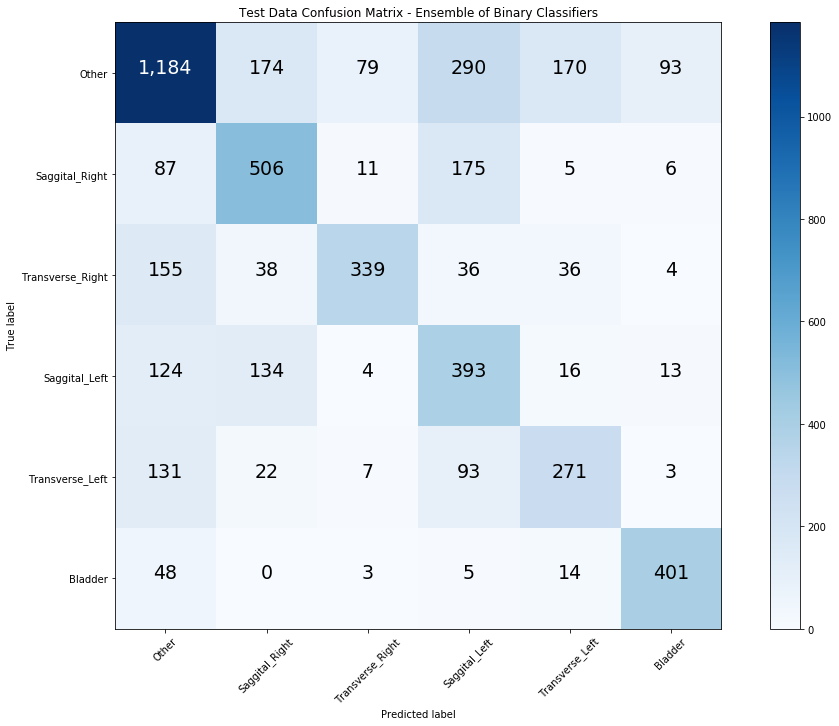

Epoch 1/1
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3756
           1       0.94      0.87      0.90      1813
           2       0.99      0.85      0.92      1284
           3       0.86      0.89      0.87      1717
           4       0.93      0.95      0.94      1286
           5       0.93      0.98      0.95      1009

    accuracy                           0.92     10865
   macro avg       0.93      0.91      0.92     10865
weighted avg       0.92      0.92      0.92     10865

{'val_Other_f1': 0.7001223990208079, 'val_Other_precision': 0.6787974683544303, 'val_Other_recall': 0.7228306655433867, 'val_Saggital_Right_f1': 0.6082474226804123, 'val_Saggital_Right_precision': 0.6483516483516484, 'val_Saggital_Right_recall': 0.5728155339805825, 'val_Transverse_Right_f1': 0.5912240184757506, 'val_Transverse_Right_precision': 0.7191011235955056, 'val_Transverse_Right_rec

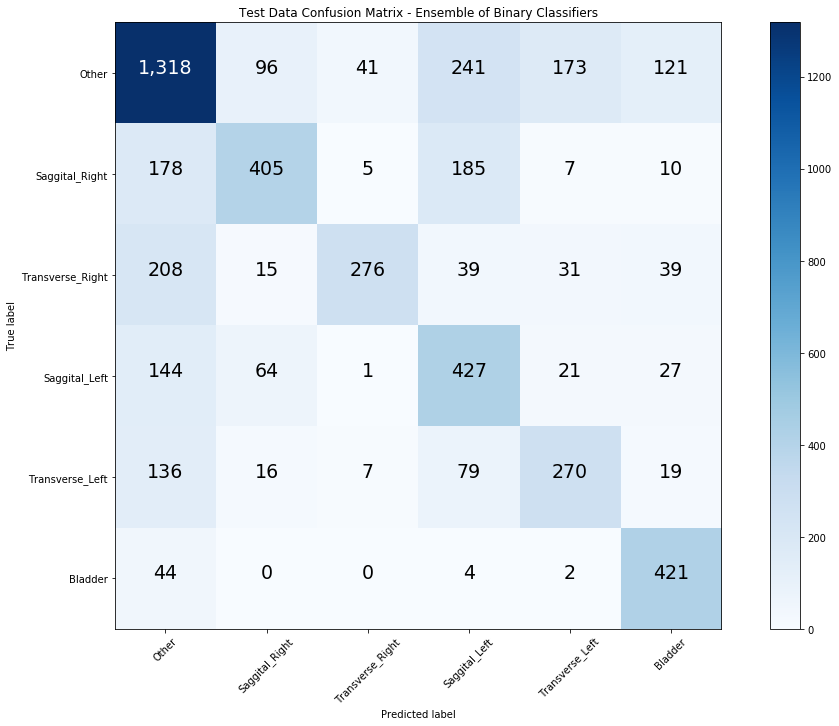

Epoch 1/1
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4432
           1       0.97      0.86      0.91      1751
           2       0.83      0.88      0.86      1195
           3       0.96      0.91      0.93      1871
           4       0.90      0.92      0.91      1296
           5       0.98      0.98      0.98      1057

    accuracy                           0.91     11602
   macro avg       0.92      0.91      0.92     11602
weighted avg       0.92      0.91      0.91     11602

{'val_Other_f1': 0.5858873841767641, 'val_Other_precision': 0.460762331838565, 'val_Other_recall': 0.8043052837573386, 'val_Saggital_Right_f1': 0.5190409026798308, 'val_Saggital_Right_precision': 0.7829787234042553, 'val_Saggital_Right_recall': 0.3881856540084388, 'val_Transverse_Right_f1': 0.5839017735334242, 'val_Transverse_Right_precision': 0.5501285347043702, 'val_Transverse_Right_reca

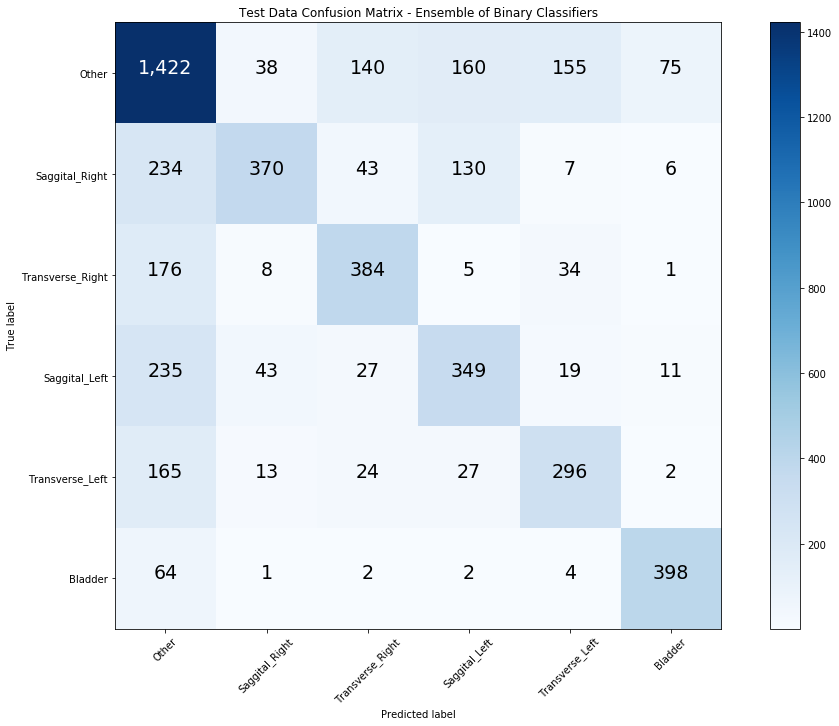

Epoch 1/1
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      3809
           1       0.71      0.75      0.73      1731
           2       0.74      0.90      0.82      1240
           3       0.96      0.72      0.82      1865
           4       0.88      0.62      0.73      1388
           5       0.99      0.96      0.97      1054

    accuracy                           0.80     11087
   macro avg       0.84      0.80      0.81     11087
weighted avg       0.81      0.80      0.80     11087

{'val_Other_f1': 0.6865109269027881, 'val_Other_precision': 0.5993421052631579, 'val_Other_recall': 0.8033509700176367, 'val_Saggital_Right_f1': 0.562019758507135, 'val_Saggital_Right_precision': 0.6139088729016786, 'val_Saggital_Right_recall': 0.5182186234817814, 'val_Transverse_Right_f1': 0.45300462249614787, 'val_Transverse_Right_precision': 0.42, 'val_Transverse_Right_recall': 0.491638

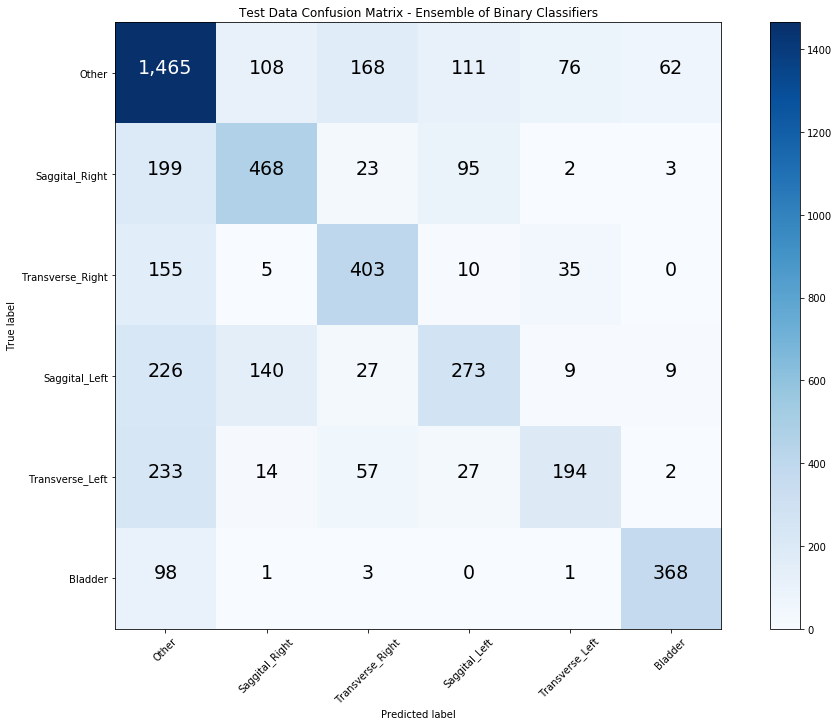

Epoch 1/1
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4051
           1       0.87      0.81      0.84      1792
           2       0.96      0.89      0.92      1219
           3       0.88      0.88      0.88      1788
           4       0.97      0.96      0.97      1347
           5       0.98      0.98      0.98      1000

    accuracy                           0.91     11197
   macro avg       0.92      0.91      0.92     11197
weighted avg       0.91      0.91      0.91     11197

{'val_Other_f1': 0.6639839034205232, 'val_Other_precision': 0.6021897810218978, 'val_Other_recall': 0.7399103139013453, 'val_Saggital_Right_f1': 0.5405405405405405, 'val_Saggital_Right_precision': 0.4914933837429111, 'val_Saggital_Right_recall': 0.6004618937644342, 'val_Transverse_Right_f1': 0.6034816247582205, 'val_Transverse_Right_precision': 0.7918781725888325, 'val_Transverse_Right_rec

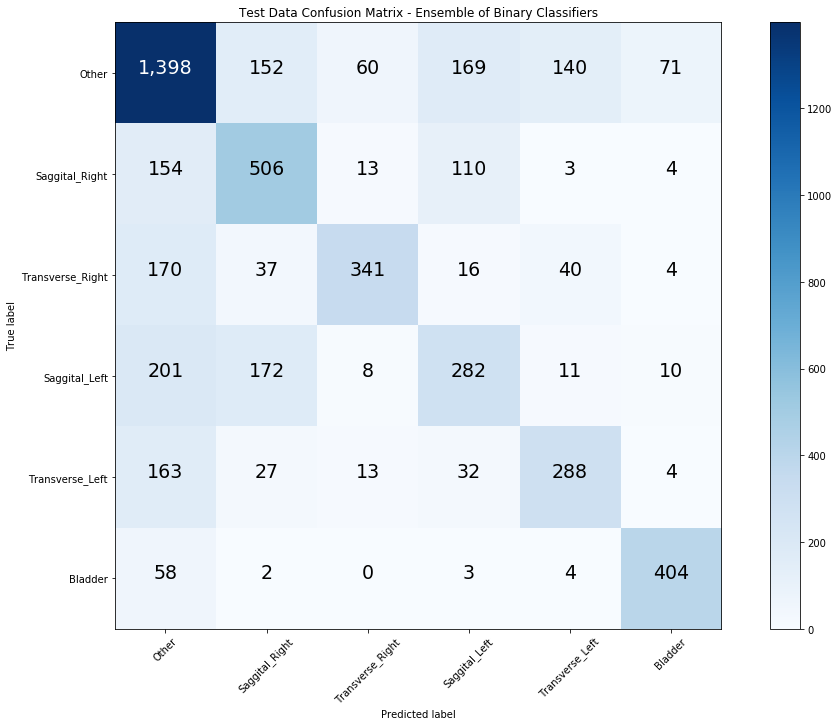

,IDs_iter_0,labels_iter_0,preds_iter_0,IDs_iter_1,labels_iter_1,preds_iter_1,IDs_iter_2,labels_iter_2,preds_iter_2,IDs_iter_3,labels_iter_3,preds_iter_3,IDs_iter_4,labels_iter_4,preds_iter_4
0,1084_4_34,4,4,1051_1_27,5,5,1003_8_72,0,0,1002_3_24,2,2,1082_8_38,0,1
1,1094_4_78,2,0,1066_2_13,1,0,1002_6_42,3,1,1002_6_41,5,5,1002_2_46,0,0
2,1010_6_109,0,0,1067_1_95,4,4,1010_6_127,3,0,1002_2_32,5,0,1060_6_47,0,0
3,1094_3_57,0,3,1060_8_10,2,2,1038_2_103,3,0,1018_1_70,0,0,1060_3_75,0,0
4,1094_4_2,1,3,1053_1_43,3,3,1066_7_3,1,1,1038_3_25,5,5,1082_5_31,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,1018_1_4,1,3,1029_1_43,5,5,1003_8_36,0,0,1051_1_58,3,0,1029_2_28,4,4
5066,1003_8_9,2,2,1066_10_8,4,0,1003_9_35,0,4,1038_2_33,0,0,1011_5_5,2,1
5067,1084_4_25,0,3,1094_4_35,3,3,1029_1_19,0,3,1029_2_39,0,0,1067_1_52,4,4
5068,1082_8_50,5,5,1066_1_16,0,0,1011_2_22,4,0,1011_2_30,5,0,1082_6_22,2,1


In [13]:
lr = 1e-4
wd = 1e-4
amsgrad = False
train5fold({'lr': lr, 'wd': wd, 'amsgrad': amsgrad}, lr, wd, amsgrad, 0)

In [14]:
'''
def SetupAndRunTest(model_ft, lr, wd, amsgrad, run_configs):
    
    input_size = 256

    # Print the model we just instantiated
    print(model_ft)

    model_ft = model_ft.to(device)

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
#     print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.Adam(params_to_update, lr=lr, weight_decay=wd, amsgrad=amsgrad)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()
    
#     model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs, is_inception=(model_name=="inception"))
'''

'\ndef SetupAndRunTest(model_ft, lr, wd, amsgrad, run_configs):\n    \n    input_size = 256\n\n    # Print the model we just instantiated\n    print(model_ft)\n\n    model_ft = model_ft.to(device)\n\n    # Gather the parameters to be optimized/updated in this run. If we are\n    #  finetuning we will be updating all parameters. However, if we are\n    #  doing feature extract method, we will only update the parameters\n    #  that we have just initialized, i.e. the parameters with requires_grad\n    #  is True.\n    params_to_update = model_ft.parameters()\n#     print("Params to learn:")\n    if feature_extract:\n        params_to_update = []\n        for name,param in model_ft.named_parameters():\n            if param.requires_grad == True:\n                params_to_update.append(param)\n                print("\t",name)\n    else:\n        for name,param in model_ft.named_parameters():\n            if param.requires_grad == True:\n                print("\t",name)\n\n    # Observe th

In [15]:
'''
repetitions = 1

conv1_filters = 8
conv2_filters = 16
conv3_filters = 32
linear1_size = 512

dropout = 0.25
lr = 0.0005
wd = 0.001
amsgrad = False
for i in range(repetitions):
    config_string = f"{conv1_filters}_{conv2_filters}_{conv3_filters}_{linear1_size}_{dropout}_{lr}_{wd}_{amsgrad}"
    model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)
    run_configs = {'lr': lr, 'wd': wd, 'amsgrad': amsgrad,'dropout': dropout, 
                  'conv1_filters': conv1_filters, 'conv2_filters': conv2_filters, 
                  'conv3_filters': conv3_filters, 'linear1_size': linear1_size }

    train5fold(run_configs, model_ft, lr, wd, amsgrad, i)

# model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)
# print(model_ft)
# num_parameters = sum(p.numel() for p in model_ft.parameters())
# print(num_parameters)
'''

'\nrepetitions = 1\n\nconv1_filters = 8\nconv2_filters = 16\nconv3_filters = 32\nlinear1_size = 512\n\ndropout = 0.25\nlr = 0.0005\nwd = 0.001\namsgrad = False\nfor i in range(repetitions):\n    config_string = f"{conv1_filters}_{conv2_filters}_{conv3_filters}_{linear1_size}_{dropout}_{lr}_{wd}_{amsgrad}"\n    model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)\n    run_configs = {\'lr\': lr, \'wd\': wd, \'amsgrad\': amsgrad,\'dropout\': dropout, \n                  \'conv1_filters\': conv1_filters, \'conv2_filters\': conv2_filters, \n                  \'conv3_filters\': conv3_filters, \'linear1_size\': linear1_size }\n\n    train5fold(run_configs, model_ft, lr, wd, amsgrad, i)\n\n# model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)\n# print(model_ft)\n# num_parameters = sum(p.numel() for p in model_ft.parameters())\n# print(num_parameters)\n'

In [16]:
# conv1_filters_size = [8, 16, 32]
# conv2_filters_size = [16, 32, 8]
# conv3_filters_size = [16, 32, 8]
# linear1_sizes = [512, 1024]
# dropouts = [0.25, 0.3]

# # lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]
# # weight_decays = [1e-5, 5e-5, 1e-4, 5e-4, 1e-6, 5e-6]
# lrs = [1e-3]
# weight_decays = [0.0005, 0.005]
# i = 0
# amsgrads=[False]
# for conv1_filters in conv1_filters_size:
#     for conv2_filters in conv2_filters_size:
#         for conv3_filters in conv3_filters_size:
#             for linear1_size in linear1_sizes:
#                 for dropout in dropouts:
#                     for lr in lrs:
#                         for wd in weight_decays:
#                             for amsgrad in amsgrads:
#                                 if i < 10:
#                                     i += 1
#                                     continue
#                                 config_string = f"{conv1_filters}_{conv2_filters}_{conv3_filters}_{linear1_size}_{dropout}_{lr}_{wd}_{amsgrad}"
#                                 model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)
#                                 run_configs = {'lr': lr, 'wd': wd, 'amsgrad': amsgrad,'dropout': dropout, 
#                                               'conv1_filters': conv1_filters, 'conv2_filters': conv2_filters, 
#                                               'conv3_filters': conv3_filters, 'linear1_size': linear1_size }

#                                 train5fold(run_configs, model_ft, lr, wd, amsgrad, i)
#                                 i += 1